In [1]:
import keras
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import matplotlib.pylab as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


## Get Data

In [2]:
!curl --ssl-no-revoke -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
 65 1810k   65 1183k    0     0   140k      0  0:00:12  0:00:08  0:00:04  261k
100 1810k  100 1810k    0     0   209k      0  0:00

## Def

In [3]:
def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

## Display images with Labels

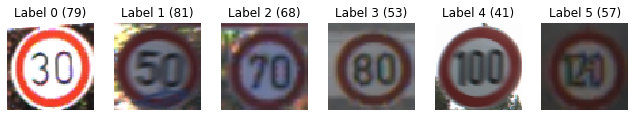

In [4]:
display_images_and_labels(images, labels)

## Modell

In [5]:
y = np.array(labels)
X = np.array(images)
num_categories = 6
y = to_categorical(y, num_categories)

In [6]:
# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)
model = Model(input=inputs, output=predictions)
print(model.summary())
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       1475

## Train

### Prepare

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [8]:
%time model.fit(X_train, y_train, epochs=3, validation_split=0.3)

Train on 25 samples, validate on 12 samples
Epoch 1/3
25/25 [==============================] - 48s 2s/step - loss: 1.7924 - accuracy: 0.2400 - val_loss: 1.7710 - val_accuracy: 0.0000e+00
Epoch 2/3
25/25 [==============================] - 6s 224ms/step - loss: 1.7199 - accuracy: 0.2800 - val_loss: 1.6489 - val_accuracy: 0.4167
Epoch 3/3
25/25 [==============================] - 8s 323ms/step - loss: 1.7025 - accuracy: 0.2400 - val_loss: 1.7587 - val_accuracy: 0.2500
Wall time: 1min 10s


# BEGIN DEPLOY WITH FULLY DATA

## Modell

In [9]:
drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)
model = Model(input=inputs, output=predictions)
print(model.summary())
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       7385

## Test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1)

In [11]:
BATCH_SIZE = 32
# To make it better, replace "epochs=10" with "epochs=100"
%time model.fit(X_train, y_train, epochs=int(input("Give me as integer the Epochs between 3 and 100: ")), batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping_callback])

Give me as integer the Epochs between 3 and 100: 20
Train on 242 samples, validate on 61 samples
Epoch 1/20
242/242 [==============================] - 59s 244ms/step - loss: 1.7549 - accuracy: 0.2025 - val_loss: 1.7844 - val_accuracy: 0.1148
Epoch 2/20
242/242 [==============================] - 46s 188ms/step - loss: 1.7244 - accuracy: 0.2355 - val_loss: 1.7879 - val_accuracy: 0.1148
Epoch 3/20
242/242 [==============================] - 46s 191ms/step - loss: 1.7308 - accuracy: 0.2769 - val_loss: 1.7849 - val_accuracy: 0.1639
Epoch 4/20
242/242 [==============================] - 49s 202ms/step - loss: 1.7095 - accuracy: 0.2355 - val_loss: 1.7776 - val_accuracy: 0.1639
Epoch 5/20
242/242 [==============================] - 49s 203ms/step - loss: 1.6753 - accuracy: 0.2397 - val_loss: 1.7680 - val_accuracy: 0.1148
Epoch 6/20
242/242 [==============================] - 48s 197ms/step - loss: 1.6736 - accuracy: 0.2355 - val_loss: 1.7684 - val_accuracy: 0.2623
Epoch 7/20
242/242 [=============

## Test

In [12]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 15s 50ms/step


(1.582699698976951, 0.3465346395969391)

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 7s 90ms/step


(1.6433468429665816, 0.28947368264198303)

## Display Image with Labels

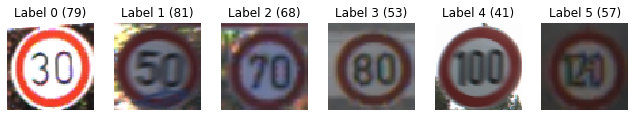

In [15]:
display_images_and_labels(images, labels)

## Test with testfiles

In [16]:
# Pick 10 random images for test data set
random.seed(int(input("Random Seed (Integer): "))) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

Random Seed (Integer): 8


array([5, 1, 5, 5, 3, 5, 1, 1, 0, 5], dtype=int64)

In [17]:
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

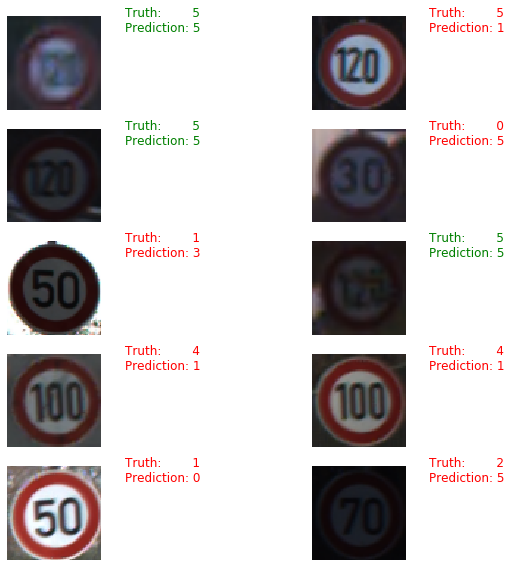

In [18]:
display_prediction(sample_images, ground_truth, predicted_categories)

## Last Run

In [19]:
def decoded(arrays):
    nusm=arrays[0]
    if(nusm==0):
        return 30
    if(nusm==1):
        return 50
    if(nusm==2):
        return 70
    if(nusm==3):
        return 80
    if(nusm==4):
        return 100
    if(nusm==5):
        return 120
def calc(numintfortest,tests):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(5, 2,1)
    sample_images = [tests[numintfortest]]
    prediction=model.predict(np.array(sample_images))
    numlock=str(decoded(np.argmax(prediction, axis=1)))
    plt.axis('off')
    plt.text(80, 10, "KI Say: \n "+numlock,fontsize=12, color="red")
    return plt.imshow(tests[numintfortest])

# USERTEST

Give me an Int between 0 and 10: 8


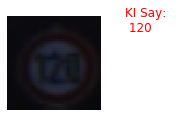

In [20]:
calc(int(input("Give me an Int between 0 and 10: ")), X_test)

Give me an Int between 0 and 100: 3


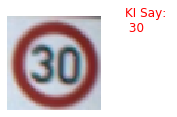

In [21]:
calc(int(input("Give me an Int between 0 and 100: ")), X_train)